In [1]:
from huggingface_hub import login
from transformers import DonutProcessor, VisionEncoderDecoderModel
from PIL import Image
import torch
import json
import re
import os
import sys
import warnings
from dotenv import load_dotenv

warnings.filterwarnings("ignore")


In [2]:
load_dotenv()
token = os.getenv("HF_TOKEN")

login(token=token)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [ ]:
# try 2 models
processor_cord = DonutProcessor.from_pretrained(
    "naver-clova-ix/donut-base-finetuned-cord-v2",
    use_fast=True  
)
model_cord = VisionEncoderDecoderModel.from_pretrained(
    "naver-clova-ix/donut-base-finetuned-cord-v2"
)

processor_base = DonutProcessor.from_pretrained(
        "naver-clova-ix/donut-base",
        use_fast=True
)
model_base = VisionEncoderDecoderModel.from_pretrained(
    "naver-clova-ix/donut-base"
)

In [4]:
image_path = "image.jpg"
image = Image.open(image_path)


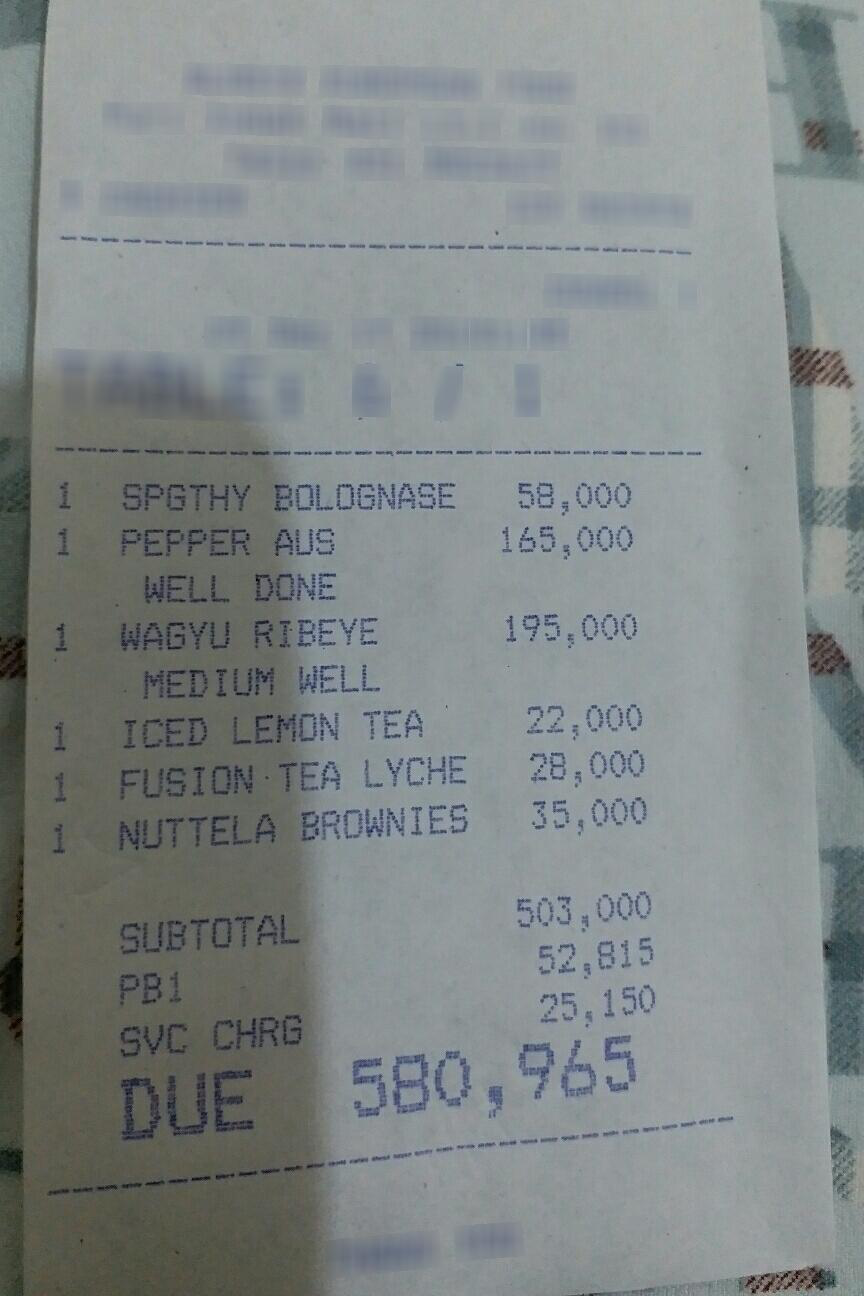

In [5]:
image

In [6]:
pixel_values_cord = processor_cord(image, return_tensors="pt").pixel_values
pixel_values_cord

tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],

         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],

         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]]])

In [7]:
# Create task prompt for CORD-v2
task_prompt_cord = "<s_cord-v2>"
decoder_input_ids_cord = processor_cord.tokenizer(
    task_prompt_cord, 
    add_special_tokens=False, 
    return_tensors="pt"
).input_ids

# Run inference for CORD-v2
with torch.no_grad():
    outputs_cord = model_cord.generate(
        pixel_values_cord, 
        decoder_input_ids=decoder_input_ids_cord, 
        max_length=512,
        num_beams=1,  
    )

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.58.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


In [8]:
# Decode CORD-v2 output
sequence_cord = processor_cord.batch_decode(outputs_cord)[0]
sequence_cord = sequence_cord.replace(processor_cord.tokenizer.eos_token, "")
sequence_cord = sequence_cord.replace(processor_cord.tokenizer.pad_token, "")
sequence_cord = re.sub(r"<.*?>", "", sequence_cord, count=1).strip()
extracted_data_cord = processor_cord.token2json(sequence_cord)

In [9]:
extracted_data_cord

{'menu': [{'nm': 'SPGTHY BOLOGNASE', 'cnt': '1', 'price': '58,000'},
  {'nm': 'PEPPER AUS',
   'cnt': '1',
   'price': '165,000',
   'sub': {'nm': 'WELL DONE'}},
  {'nm': 'WAGYU RIBEYE',
   'cnt': '1',
   'price': '195,000',
   'sub': {'nm': 'MEDIUM WELL'}},
  {'nm': 'ICED LEMON TEA', 'cnt': '1', 'price': '22,000'},
  {'nm': 'FUSION TEA LYCHE', 'cnt': '1', 'price': '28,000'},
  {'nm': 'NUTTELA BROWNIES', 'cnt': '1', 'price': '35,000'}],
 'sub_total': {'subtotal_price': '503,000',
  'service_price': '25,150',
  'tax_price': '52,815'},
 'total': {'total_price': '580,965'}}

In [ ]:
# Create task prompt for donut base
pixel_values_base = processor_base(image, return_tensors="pt").pixel_values
task_prompt_base = "Extract all menu items, quantities, prices, subtotal, and total from the receipt in JSON format"
decoder_input_ids_base = processor_base.tokenizer(
    task_prompt_base, 
    add_special_tokens=False, 
    return_tensors="pt"
).input_ids

with torch.no_grad():
    outputs_base = model_base.generate(
        pixel_values_base, 
        decoder_input_ids=decoder_input_ids_base,
        num_beams=1,
    )

In [ ]:
# Decode donut base output
sequence_docvqa = processor_base.batch_decode(outputs_base)[0]
sequence_docvqa = sequence_docvqa.replace(processor_base.tokenizer.eos_token, "")
sequence_docvqa = sequence_docvqa.replace(processor_base.tokenizer.pad_token, "")
sequence_docvqa = re.sub(r"<.*?>", "", sequence_docvqa, count=1).strip()
extracted_data_base = processor_base.token2json(sequence_docvqa)


In [22]:
extracted_data_base

{'text_sequence': 'Extract all menu items, quantities, prices, subtotal, and total from the receipt in JSON format, SPG THY BDLDGNASE PEPPER AUG . WELL'}

From two models before, donut-base-finetuned-cord-v2 is better result than donut-base. donut-base-finetuned-cord-v2 can extract more information than donut-base.

In [23]:
items = []
subtotal = 0.0
total = 0.0

if 'menu' in extracted_data_cord:
    for item in extracted_data_cord['menu']:
        name = item.get('nm', 'Unknown Item')
        qty = float(item.get('cnt', 1))
        price = float((item.get('price', 0)).replace(',', ''))
        item_total = float(item.get('sub_total', qty * price))
        items.append({
            'name': name, 
            'qty': qty, 
            'price': price, 
            'total': item_total
        })
        subtotal += item_total

In [24]:
subtotal

503000.0

In [25]:
items

[{'name': 'SPGTHY BOLOGNASE', 'qty': 1.0, 'price': 58000.0, 'total': 58000.0},
 {'name': 'PEPPER AUS', 'qty': 1.0, 'price': 165000.0, 'total': 165000.0},
 {'name': 'WAGYU RIBEYE', 'qty': 1.0, 'price': 195000.0, 'total': 195000.0},
 {'name': 'ICED LEMON TEA', 'qty': 1.0, 'price': 22000.0, 'total': 22000.0},
 {'name': 'FUSION TEA LYCHE', 'qty': 1.0, 'price': 28000.0, 'total': 28000.0},
 {'name': 'NUTTELA BROWNIES', 'qty': 1.0, 'price': 35000.0, 'total': 35000.0}]

In [28]:
if 'total' in extracted_data_cord:
    if isinstance(extracted_data_cord['total'], dict):
        total = float(extracted_data_cord['total'].get('total_price', 0).replace(',', ''))

additional_fees = total - subtotal


In [29]:
subtotal

503000.0

In [30]:
additional_fees

77965.0

In [31]:
total

580965.0